# Introduction
我们希望通过深度学习进行情感预测，尝试超越传统机器学习算法的情感分析表现。

我们主要探索下列方面：
*使用适应深度学习模型
*识别并处理过度拟合
*使用单词嵌入
*建立在预先训练的模型上



# Set-up of the project
We'll start by importing some packages.

In [37]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
# from keras import models
# from keras import layers
# from keras import regularizers
import pickle

Then we set some parameters that will be used throughout the notebook.

In [38]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

We read in the csv with the tweets data and perform a random shuffle. It's a good practice to shuffle the data before splitting between a train and test set. That way the sentiment classes are equally distributed over the train and test sets.

We'll only keep the *text* column as input and the *airline_sentiment* column as the target. 

In [39]:
df = pd.read_csv('data/Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
8434,@JetBlue Marks 15th Year With 'Bluemanity' Pla...,neutral
4099,"@united if your policy changed, you must advis...",negative
11934,@AmericanAir did you know that suicide is the ...,neutral
8912,@JetBlue was just at T5 a little over a month ...,positive
9703,@USAirways I made a reservation online but I d...,negative


# Data preparation

### Data cleaning
The first thing we'll do is removing stopwords. These words do not have any value for predicting the sentiment. Furthermore, as we want to build a model that can be used for other airline companies as well, we remove the mentions.

In [40]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head()

,text,airline_sentiment
8434,Marks 15th Year With 'Bluemanity' Plane Desig...,neutral
4099,"policy changed, must advise time purchase. Sa...",negative
11934,know suicide second leading cause death among...,neutral
8912,T5 little month ago. guys great thanks every...,positive
9703,made reservation online receive confirmation ...,negative


### Train-Test split
The evaluation of the model performance needs to be done on a separate test set. As such, we can estimate how well the model generalizes. This is done with the *train_test_split* method of scikit-learn.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13176
# Test data samples: 1464


### Converting words to numbers
To use the text as input for a model, we first need to convert the tweet's words into tokens, which simply means converting the words to integers that refer to an index in a dictionary. Here we will only keep the most frequent words in the train set.

We clean up the text by applying *filters* and putting the words to *lowercase*. Words are separated by spaces.

In [42]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 13176 documents
10000 words in dictionary
Top 5 most common words are: [('flight', 3531), ('not', 1456), ('no', 1336), ('get', 1216), ('t', 1092)]


After having created the dictionary we can convert the text to a list of integer indexes. This is done with the *text_to_sequences* method of the Tokenizer.

In [43]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
# print('X_train_seq', X_train_seq[0])
print('X_train',X_train[0], '#'*10, X_train[1],'@'*10, X_train[2])
print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

KeyError: 2

These integers should now be converted into a one-hot encoded features.

In [ ]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

### Converting the target classes to numbers
We need to convert the target classes to numbers as well, which in turn are one-hot-encoded with the *to_categorical* method in keras

In [ ]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

myindex = 0
for i in range(0,10):
    myindex = i
    print('"{}" is converted into {}'.format(y_train[myindex], y_train_le[myindex]))
    print('"{}" is converted into {}'.format(y_train_le[myindex], y_train_oh[myindex]))


# print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
# print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

### Splitting of a validation set
Now that our data is ready, we split of a validation set. This validation set will be used to evaluate the model performance when we tune the parameters of the model. 

In [44]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1318, 10000)


# Deep learning

### Baseline model
We start with a model with 2 densely connected layers of 64 hidden elements. The *input_shape* for the first layer is equal to the number of words we allowed in the dictionary and for which we created one-hot-encoded features.

As we need to predict 3 different sentiment classes, the last layer has 3 hidden elements. The *softmax* activation function makes sure the three probabilities sum up to 1.

In the first layer we need to estimate 640064 weights. This is determined by (nb inputs * nb hidden elements) + nb bias terms, or (10000 x 64) + 64 = 640064<br>
In the second layer we estimate (64 x 64) + 64 = 4160 weights<br>
In the last layer we estimate (64 x 3) + 3 = 195 weights<br>

In [45]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 64)                640064    
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


Because this project is a multi-class, single-label prediction, we use *categorical_crossentropy* as the loss function and *softmax* as the final activation function. We fit the model on the remaining train data and validate on the validation set. We run for a predetermined number of epochs and will see when the model starts to overfit.

In [46]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [47]:
base_history = deep_model(base_model)

2022-09-05 17:55:02.752994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-05 17:55:03.233970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


To evaluate the model performance, we will look at the training and validation loss and accuracy.

In [48]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

We can see here that the validation loss starts to increase as from epoch 4. The training loss continues to lower, which is normal as the model is trained to fit the train data as good as possible.

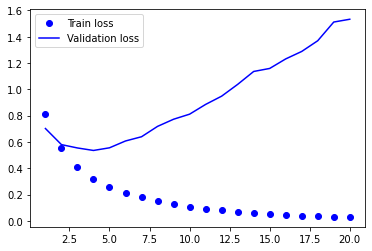

In [49]:
eval_metric(base_history, 'loss')

Just as with the validation loss, the validation accuracy peaks at an early epoch. After that, it goes down slightly. So to conclude, we can say that the model starts overfitting as from epoch 4. 

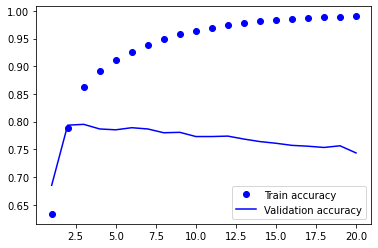

In [50]:
eval_metric(base_history, 'accuracy')

### Handling overfitting
Now, we can try to do something about the overfitting. There are different options to do that.
* Option 1: reduce the network's size by removing layers or reducing the number of hidden elements in the layers
* Option 2: add regularization, which comes down to adding a cost to the loss function for large weights
* Option 3: adding dropout layers, which will randomly remove certain features by setting them to zero

#### Reducing the network's size
We reduce the network's size by removing one layer and lowering the number of hidden elements in the remaining layer to 32.

In [51]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 32)                320032    
                                                                 
 dense_15 (Dense)            (None, 3)                 99        
                                                                 
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [52]:
reduced_history = deep_model(reduced_model)

2022-09-05 17:55:08.283715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-05 17:55:08.687076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [53]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

We can see that it takes more epochs before the reduced model starts overfitting (around epoch 10). Moreover, the loss increases much slower after that epoch compared to the baseline model.

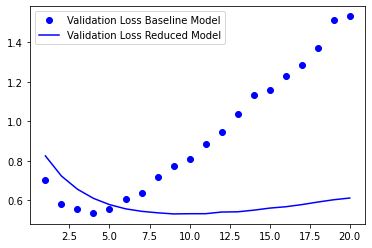

In [54]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

#### Adding regularization
To address overfitting, we can also add regularization to the model. Let's try with L2 regularization.

In [55]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                640064    
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [56]:
reg_history = deep_model(reg_model)

2022-09-05 17:55:13.472671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-05 17:55:13.967986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


For the regularized model we notice that it starts overfitting earlier than the baseline model. However, the loss increases much slower afterwards.

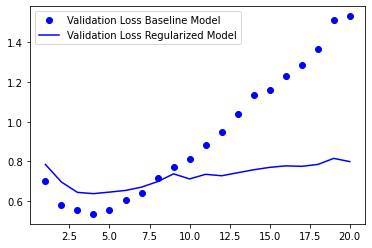

In [57]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

#### Adding dropout layers
The last option we'll try is to add dropout layers.

In [58]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 64)                640064    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [59]:
drop_history = deep_model(drop_model)

2022-09-05 17:55:19.252920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-05 17:55:19.763195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


The model with dropout layers starts overfitting a bit later than the baseline model. The loss also increases slower than the baseline model.

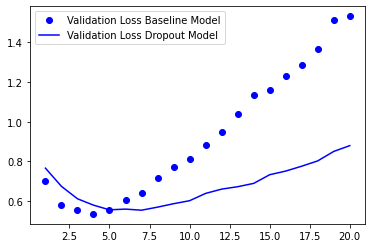

In [60]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

### Training on the full train data and evaluation on test data
At first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [61]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [62]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

46/46 [==============================] - 0s 7ms/step - loss: 1.1781 - accuracy: 0.7780
/n
Test accuracy of baseline model: 77.80%


In [63]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

46/46 [==============================] - 0s 7ms/step - loss: 0.6879 - accuracy: 0.7889
/n
Test accuracy of reduced model: 78.89%


In [64]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

46/46 [==============================] - 0s 7ms/step - loss: 0.7412 - accuracy: 0.7883
/n
Test accuracy of regularized model: 78.83%


In [65]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

46/46 [==============================] - 0s 8ms/step - loss: 0.8932 - accuracy: 0.7937
/n
Test accuracy of dropout model: 79.37%


# Conclusion
As we can see above, the model with the dropout layers performs the best on the test data. However, this is slightly lower than what we achieved with a LogisticRegression and Countvectorizer in my previous kernel. But there the input data was transformed a bit different than here. 

### What's next?
Soon I will add the use of word embeddings in Keras and using a pretrained model. To be continued...

In [66]:
print('-'*20, 'save model')
filename = "finalized_model.sav"
drop_model.save('drop_model.h5')  # creates a HDF5 file 'my_model.h5'

-------------------- save model


In [67]:
import tensorflow as tf 
# identical to the previous one
mymodel = tf.keras.models.load_model('drop_model.h5')


In [68]:
drop_results = test_model(mymodel, 6)
print('again /n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

2022-09-05 17:55:33.259213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/46 [=========>....................] - ETA: 0s - loss: 1.1832 - accuracy: 0.7754

2022-09-05 17:55:35.059311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 0s 7ms/step - loss: 1.0874 - accuracy: 0.7910
again /n
Test accuracy of dropout model: 79.10%


In [69]:
print(X_test_oh[0], type(X_test_oh))
with open('test.pkl','wb') as f:
     pickle.dump(X_test_oh[0:100], f)
        
with open('test.pkl','rb') as f:
     MyX_test_oh = pickle.load(f)           
# for i in X_test_oh[0]:
#     print(i)
for i in  range(20):
    q = mymodel.predict( np.array( [MyX_test_oh[i],] )  )
    print(i, 'q=', np.around(q,decimals=3))


[0. 1. 0. ... 0. 0. 0.] <class 'numpy.ndarray'>
0 q= [[1. 0. 0.]]
1 q= [[1. 0. 0.]]
2 q= [[0.99 0.01 0.  ]]
3 q= [[0.663 0.095 0.241]]
4 q= [[0.03  0.002 0.969]]
5 q= [[0.997 0.003 0.   ]]
6 q= [[0.013 0.039 0.948]]
7 q= [[0.999 0.    0.   ]]
8 q= [[1. 0. 0.]]


2022-09-05 17:55:35.455095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9 q= [[0.1 0.9 0. ]]
10 q= [[0.018 0.016 0.966]]
11 q= [[0.483 0.055 0.462]]
12 q= [[0.    0.002 0.998]]
13 q= [[1. 0. 0.]]
14 q= [[0.781 0.193 0.027]]
15 q= [[0.01  0.039 0.95 ]]
16 q= [[0.649 0.257 0.095]]
17 q= [[0.042 0.958 0.   ]]
18 q= [[0.994 0.006 0.   ]]
19 q= [[0.016 0.942 0.042]]
